открываем сверху вкладку Runtime -> change Runtime type: <br>
Runtime type: Python3<br>
Hardware accelerator: GPU

In [0]:
!git clone https://github.com/chamecall/scripts.git
!unzip scripts/train_detectron/train_detectron2.zip -d detectron_train

Распаковываем архив<br>
# Содержимое архива:
*   detecton2/ - фреймворк детектирования объектов, можно забрать [здесь](https://github.com/facebookresearch/detectron2.git), здесь нам нужны только конфиги
*   images/ - каталог с изображениями (train - для обучения, val - для валидации)
*   annotations/ - каталог с файлами разметки (train - для обучения, val - для валидацииодин файл на одно изображение)
*   pascal_voc_xml2json.py - скрипт конвертирования файлов разметки из xml файлов(Pascal VOC) в json формат(COCO)

# Данный шаг объясняет процесс создания каталогов images/ и annotations/

скачиваем labelimg для разметки изображений [здесь](https://tzutalin.github.io/labelImg/)<br>

детекции по каждому классу нужно разделить на две части в отношении 90%/10% на тренировочные данные и валидационные (images/train и images/val)<br>

далее размечаем изображения каждого каталога (train и val) в labelimg:<br>
*   Open Dir - указываем каталог, в котором хранятся изображения(image/train или images/val)
*   Change Save Dir - указываем каталог, где будем хранить размеченные xml файлы (annotations/train или annotations/val)

у нам всего 7 изображений, на каждом из которых изображено два класса (cat и dog). 5 изображений мы используем для обучения (по 5 сэмплов каждого класса соответственно) и 2 для валидации (по 2 сэмпла каждого класса соответственно)



Cтавим detectron

In [0]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [11]:
%cd detectron_train/
!ls

[Errno 2] No such file or directory: 'detectron_train/'
/content/detectron_train/detectron_train
annotations  detectron2  images  pascal_voc_xml2json.py


конвертируем размеченные xml файлы в json формат..<br>
на выходе получаем 2 json файла:
*   для обучения
*   для валидации

In [16]:
!python pascal_voc_xml2json.py -annot annotations/train
!python pascal_voc_xml2json.py -annot annotations/val

!ls *.json

train.json  val.json


In [0]:
import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import cv2
import random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

регистрируем датасеты

In [0]:
register_coco_instances('train_set', {}, './train.json', './images/train')
register_coco_instances('val_set', {}, './val.json', './images/val')


получаем тренировочные метаданные с нашими классами и наш тренировочный датасет, сконвертированный в формат detectron-a (по словарю на изображение)

In [19]:
train_metadata_catalog = MetadataCatalog.get('train_set')
train_dataset_catalog = DatasetCatalog.get('train_set')
train_metadata_catalog.thing_classes

['cat', 'dog']

визуализируем случайные размеченные выборки из тренировочного набора

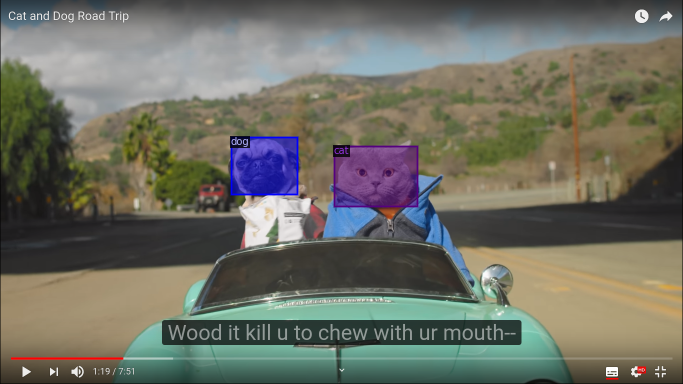

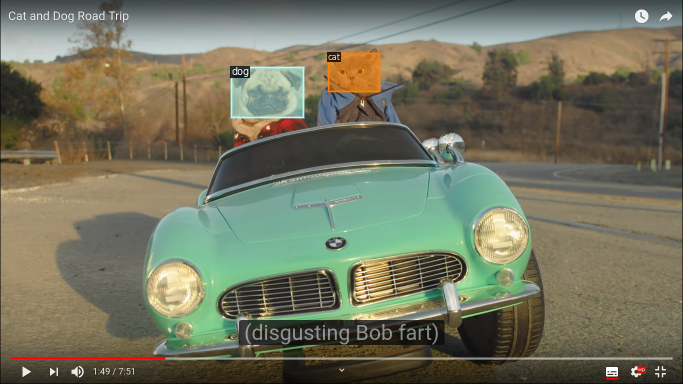

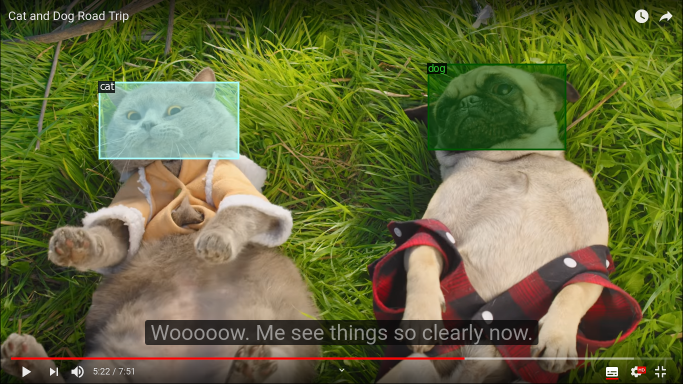

In [20]:
samples_no = 3
for d in random.sample(train_dataset_catalog, samples_no):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata_catalog, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


#настройка конфигурации и обучение

показателем успешного обучения является уменьшающееся значение ошибки ("total_loss")

In [26]:
cfg = get_cfg()
# конфиг сети
cfg.merge_from_file('./detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml')
# указываем наши зарегистрированные датасеты
cfg.DATASETS.TRAIN = ('train_set',)
cfg.DATASETS.TEST = ('val_set',)
cfg.DATALOADER.NUM_WORKERS = 2
# инициализируем сеть предтренированными весами (обучение происходит чуть быстрее, чем на случайно инициализированных)
cfg.MODEL.WEIGHTS = 'detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
# количество эпох (итераций) прохождения по всем изображениям
cfg.SOLVER.MAX_ITER = (250)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
# количество категорий, у нас две [cat, dog]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# создаем каталог для обученных весов
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
# запускаем тренировку
trainer.train()

[04/02 18:29:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.


[04/02 18:29:40 d2.engine.train_loop]: Starting training from iteration 0
[04/02 18:30:00 d2.data.datasets.coco]: Loaded 2 images in COCO format from ./val.json
[04/02 18:30:00 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[04/02 18:30:00 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [04/02 18:30:00 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[04/02 18:30:00 d2.utils.events]:  eta: 0:00:00  iter: 19  total_loss: 1.578  loss_cls: 0.755  loss_box_reg: 0.807  loss_rpn_cls: 0.013  loss_rpn_loc: 0.012  time: 0.9242  data_time: 0.0180  lr: 0.000400  max_mem: 4592M
[04/02 18:30:00 d2.engine.hooks]: Overall training speed: 17 iterations in 0:00:16 (0.9785 s / it)
[04/02 18:30:00 d2.engine.hooks]: Total training time: 0:00:18 (0:00:02 on hooks)


в текущей директории был создан каталог output, в нем находятся обученные веса (model_final.pth)<br>
получаем наши классы;<br>
инициализируем модель обученными весами;<br>
получаем валидационный датасет

In [29]:
from detectron2.data.catalog import Metadata

metadata = Metadata()
metadata.set(thing_classes = train_metadata_catalog.thing_classes)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)
val_dataset_catalog = DatasetCatalog.get('val_set')

[04/02 18:31:29 d2.data.datasets.coco]: Loaded 2 images in COCO format from ./val.json


на валидационном датасете(из 2 изображений) пропускаем сеть с обученными весами и визуализируем результаты 

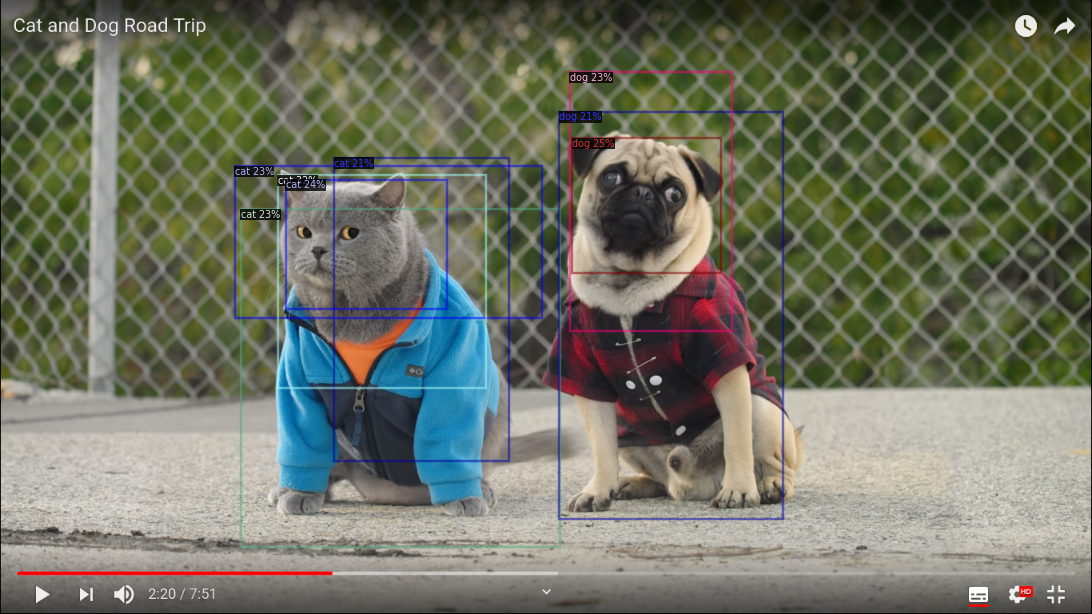

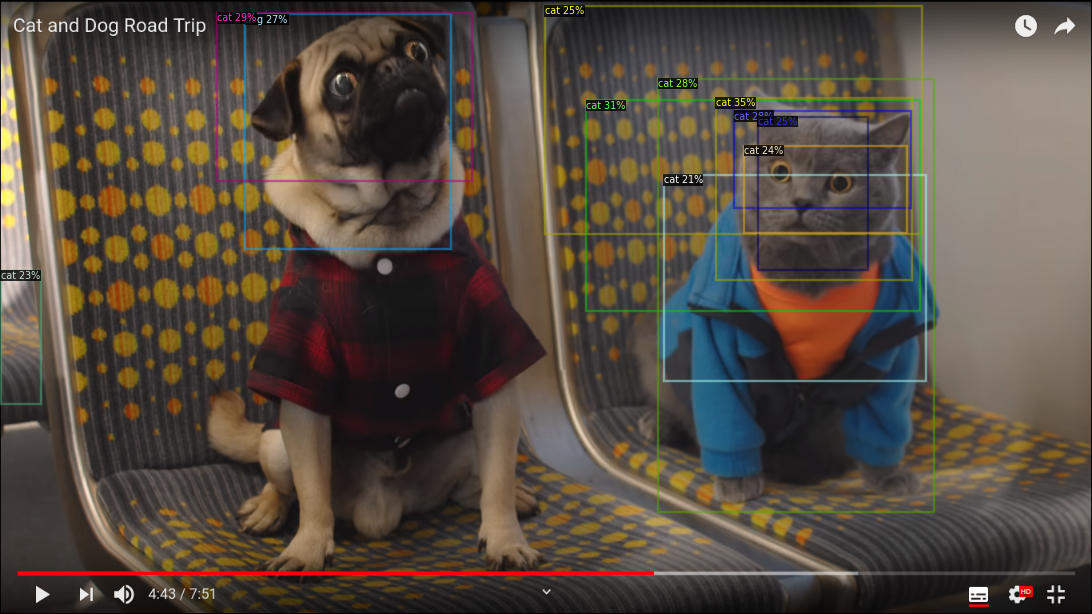

In [30]:

for d in random.sample(val_dataset_catalog, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])